# 03 — Merton & KMV Probability of Default (PD) Model

This notebook:
- Loads volatility (σE), market cap (E), and debt (D)
- Applies Merton's structural model:
    - Solve V (asset value)
    - Solve σV (asset volatility)
    - Compute d1, d2
    - Compute Merton PD = N(-d2)
- Applies KMV approach:
    - Compute Default Point (DP) = ST + 0.5 * LT
    - Compute Distance to Default (DD)
    - Compute KMV PD = N(-DD)
- Saves results to `merton_kmv_results.csv`
- Produces comparison plots for all banks

In [1]:
import sys
import os

# Add project root to Python path
sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("."))  

# If src is directly under your notebook folder:
sys.path.append(os.path.abspath("./src"))

In [ ]:
import pandas as pd
from pathlib import Path

from src.utils import load_config, ensure_folder, read_fundamentals
from src.merton_solver import solve_merton
from src.kmv_merton import compute_kmv_metrics, kmv_default_point

cfg = load_config("../config.yaml")
ensure_folder(cfg["output_folder"])

tickers = cfg["tickers"]
r = cfg["risk_free_rate"]
T = cfg["T"]

price_folder = cfg["price_data_folder"]

In [ ]:
vol_df = pd.read_csv(Path(cfg["output_folder"]) / "volatility_results.csv")
mc_df  = pd.read_csv(Path(cfg["output_folder"]) / "marketcap_FY2025.csv")

fund_df_1 = pd.read_csv("../outputs/fundamentals_processed.csv")
fund_df_1

In [ ]:
# Ensure Ticker column exists and matches join key
fund_df = fund_df_1.rename(columns={"ticker": "Ticker"})

# Merge volatility, market cap, and debt (including ST/LT debt for KMV)
# Check available columns in fundamentals
print("Fundamentals columns:", fund_df.columns.tolist())

# Merge based on available columns
merge_cols = ["Ticker", "debt_facevalue"]
if "short_term_debt" in fund_df.columns:
    merge_cols.append("short_term_debt")
if "long_term_debt" in fund_df.columns:
    merge_cols.append("long_term_debt")

inputs = (
    vol_df
    .merge(mc_df[["Ticker", "Market_Cap_Rupees"]], on="Ticker")
    .merge(fund_df[merge_cols], on="Ticker")
)

inputs

,Ticker,Sigma_E,Market_Cap_Rupees,debt_facevalue
0,SBIBANK,0.299478,6.749811e+12,4.619989e+13
1,BANKBARODA,0.395868,1.142440e+12,1.854015e+13
2,CANBK,0.399892,7.798717e+11,2.293394e+13
3,HDFCBANK,0.246321,4.604539e+12,1.651468e+13
4,ICICIBANK,0.286065,4.768774e+12,1.176310e+13
5,AXISBANK,0.322907,3.411764e+12,9.286845e+12
6,KOTAKBANK,0.267515,4.312501e+12,1.079711e+13
7,INDUSINDBK,0.429140,5.065224e+11,4.371560e+12
8,BAJFINANCE,0.342022,5.519552e+12,1.927424e+12
9,PNB,0.394363,1.076333e+12,1.119953e+13


In [ ]:
pd_results = []

for _, row in inputs.iterrows():
    ticker = row["Ticker"]
    E = float(row["Market_Cap_Rupees"])
    sigma_e = float(row["Sigma_E"])
    D = float(row["debt_facevalue"])
    
    # Get ST/LT debt for KMV (use total debt / 2 as fallback if not available)
    st_debt = float(row.get("short_term_debt", D * 0.5))
    lt_debt = float(row.get("long_term_debt", D * 0.5))

    # Solve Merton model
    sol = solve_merton(E, sigma_e, D, r, T)
    
    # Compute KMV metrics using solved V and sigma_V
    kmv = compute_kmv_metrics(sol["V"], sol["Sigma_V"], st_debt, lt_debt)

    pd_results.append({
        "Ticker": ticker,
        "E": E,
        "Sigma_E": sigma_e,
        "D_total": D,
        "ST_debt": st_debt,
        "LT_debt": lt_debt,
        "V": sol["V"],
        "Sigma_V": sol["Sigma_V"],
        "d1": sol["d1"],
        "d2": sol["d2"],
        "Merton_PD": sol["PD"],
        "KMV_DP": kmv["DP"],
        "KMV_DD": kmv["DD"],
        "KMV_PD": kmv["PD_KMV"]
    })

pd_df = pd.DataFrame(pd_results)
pd_df

,Ticker,E,Sigma_E,D,V,Sigma_V,d1,d2,PD
0,SBIBANK,6.749811e+12,0.299478,4.619989e+13,5.047724e+13,0.040052,3.603957,3.563905,1.826893e-04
1,BANKBARODA,1.142440e+12,0.395868,1.854015e+13,1.868976e+13,0.024310,2.605245,2.580936,4.926649e-03
2,CANBK,7.798717e+11,0.399892,2.293394e+13,2.248594e+13,0.013948,2.535908,2.521961,5.835139e-03
3,HDFCBANK,4.604539e+12,0.246321,1.651468e+13,2.023544e+13,0.056050,4.634377,4.578328,2.343542e-06
4,ICICIBANK,4.768774e+12,0.286065,1.176310e+13,1.590237e+13,0.085786,4.198595,4.112809,1.954366e-05
5,AXISBANK,3.411764e+12,0.322907,9.286845e+12,1.220159e+13,0.090301,3.677101,3.586801,1.673799e-04
6,KOTAKBANK,4.312501e+12,0.267515,1.079711e+13,1.453180e+13,0.079389,4.474345,4.394957,5.539746e-06
7,INDUSINDBK,5.065224e+11,0.429140,4.371560e+12,4.643654e+12,0.047127,2.471895,2.424768,7.659086e-03
8,BAJFINANCE,5.519552e+12,0.342022,1.927424e+12,7.343830e+12,0.257060,5.546235,5.289175,6.143469e-08
9,PNB,1.076333e+12,0.394363,1.119953e+13,1.167602e+13,0.036493,2.667083,2.630590,4.261841e-03


In [ ]:
out_path = Path(cfg["output_folder"]) / "merton_kmv_results.csv"
pd_df.to_csv(out_path, index=False)

print("✓ Merton & KMV PD estimation complete.")
print("Saved to:", out_path)

✓ Merton PD estimation complete.
Saved to: ../outputs/merton_pd_results.csv


### Merton vs KMV PD Comparison Plot

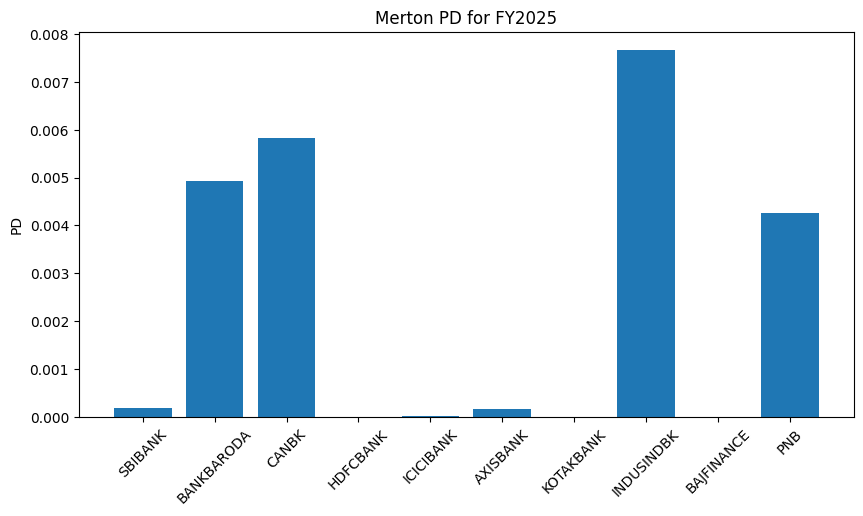

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Merton PD
ax1 = axes[0]
ax1.bar(pd_df["Ticker"], pd_df["Merton_PD"], color='steelblue')
ax1.set_title("Merton PD for FY2025")
ax1.set_ylabel("Probability of Default")
ax1.set_xticklabels(pd_df["Ticker"], rotation=45, ha='right')

# Plot 2: KMV PD
ax2 = axes[1]
ax2.bar(pd_df["Ticker"], pd_df["KMV_PD"], color='darkorange')
ax2.set_title("KMV PD for FY2025")
ax2.set_ylabel("Probability of Default")
ax2.set_xticklabels(pd_df["Ticker"], rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
# Side-by-side comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(pd_df["Ticker"]))
width = 0.35

bars1 = ax.bar(x - width/2, pd_df["Merton_PD"], width, label='Merton PD', color='steelblue')
bars2 = ax.bar(x + width/2, pd_df["KMV_PD"], width, label='KMV PD', color='darkorange')

ax.set_xlabel('Bank')
ax.set_ylabel('Probability of Default')
ax.set_title('Merton vs KMV Probability of Default - FY2025')
ax.set_xticks(x)
ax.set_xticklabels(pd_df["Ticker"], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

# Summary statistics
print("\n=== Summary Statistics ===")
print(f"Average Merton PD: {pd_df['Merton_PD'].mean():.4%}")
print(f"Average KMV PD:    {pd_df['KMV_PD'].mean():.4%}")
print(f"\nHighest Risk (Merton): {pd_df.loc[pd_df['Merton_PD'].idxmax(), 'Ticker']} ({pd_df['Merton_PD'].max():.4%})")
print(f"Lowest Risk (Merton):  {pd_df.loc[pd_df['Merton_PD'].idxmin(), 'Ticker']} ({pd_df['Merton_PD'].min():.4%})")